import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"
import theano

In [1]:
import sys
if '/' in sys.path[0]:
    sys.path.append(r'/home/elisa/PycharmProjects/gempy')
elif '\\' in sys.path[0]:
    sys.path.append(r'C:/users/elisa/documents/git/gempy')

import gempy as gp
#import vtk


import numpy as np
import matplotlib.pyplot as plt

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

In [2]:
# for plotting
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=1)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### 1. Regular model setup

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[ 166.66666667,  166.66666667,  166.66666667],
       [ 166.66666667,  166.66666667,  500.        ],
       [ 166.66666667,  166.66666667,  833.33333333],
       ...,
       [1000.        ,  200.        ,  974.6835443 ],
       [1000.        ,  200.        ,  987.34177215],
       [1000.        ,  200.        , 1000.        ]])

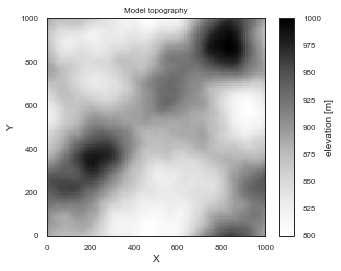

In [3]:
geo_model = gp.create_model('FaultModel')
gp.init_data(geo_model, extent=[0,1000,0,1000,0,1000],resolution = [3,3,3],
                         path_i = r"data/faultuncertainty_interfaces_surface.csv",
                         path_o = r"data/faultuncertainty_orient_surface.csv")

gp.map_series_to_surfaces(geo_model, {'fault_series':'fault','form_series':('layer2','layer1','basement')})
geo_model.surfaces.colors.change_colors({'layer1': '#ffbe00', 'layer2': '#9f0052', 'fault': '#015482',
                                        'basement': '#728f02'})

geo_model.set_is_fault(['fault_series'],change_color=False)

geo_model.set_section_grid({'s1':([0,200],[1000,200],[80,80])})#p1,p2,resolution
geo_model.set_topography(source='saved', filepath='topo.npy')

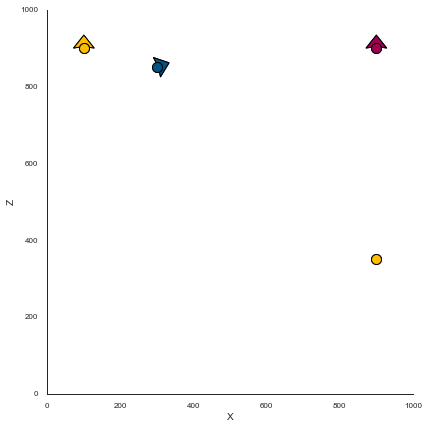

In [4]:
gp.plot.plot_data(geo_model, direction='y')

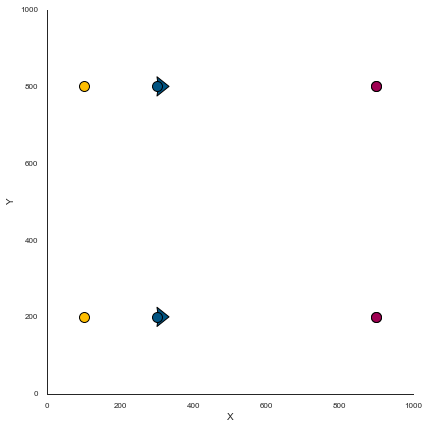

In [5]:
gp.plot.plot_data(geo_model, direction='z')

In [6]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                   values
range            1732.05
$C_o$            71428.6
drift equations   [3, 3]


In [7]:
sol = gp.compute_model(geo_model, compute_mesh=False)

1000
0


C:/users/elisa/documents/git/gempy\gempy\plot\visualization_2d.py:208: UserWarning: the orientations are not converted to apparent dip.
  warnings.warn('the orientations are not converted to apparent dip.')


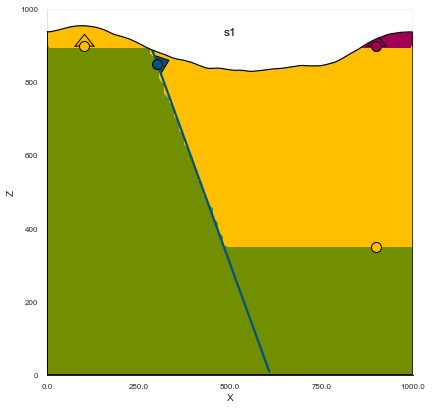

In [8]:
_=gp.plot.plot_section_by_name(geo_model, 's1', show_data=True, radius=50)

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'zlevel'
  s)


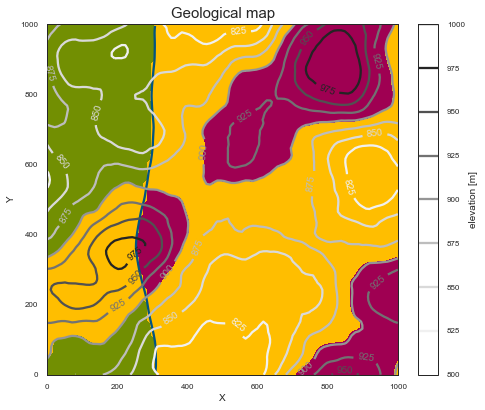

In [9]:
gp.plot.plot_map(geo_model, show_data=False, figsize=(7,7))

### 2. Stochastic simulation

##### as an example: code to perturb location of fault once. 

1000
0


C:/users/elisa/documents/git/gempy\gempy\plot\visualization_2d.py:208: UserWarning: the orientations are not converted to apparent dip.
  warnings.warn('the orientations are not converted to apparent dip.')


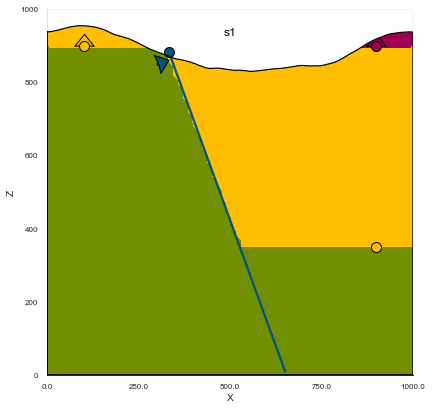

In [10]:
# execute this cell a couple of times and see how location of fault in section changes

mask_surfpoints = geo_model.surface_points.df.surface.isin(['fault']) # perturb only fault
indexes = geo_model.surface_points.df[mask_surfpoints].index

rand_val = np.random.uniform(-100, 100)
we = geo_model.surface_points.df['X'].values[mask_surfpoints] + rand_val
ns = geo_model.surface_points.df['Y'].values[mask_surfpoints] + rand_val
d = geo_model.surface_points.df['Z'][mask_surfpoints] + rand_val
geo_model.modify_surface_points(indexes, X=we, Y=ns, Z=d)

geo_model.update_to_interpolator()

_=gp.compute_model(geo_model, compute_mesh=False)

_=gp.plot.plot_section_by_name(geo_model, 's1', show_data=True, radius=50)

### Full simulation in loop with probability calculation

In [11]:
from tqdm import tqdm_notebook as tqdm

##### Init probability blocks

In [12]:
# unique lith ids
lith_id = np.unique(np.round(geo_model.solutions.sections[0]).astype(int))

# setup solution arrays
geomap  = np.round(geo_model.solutions.geological_map[0]).astype(int).ravel()
section1  = np.round(geo_model.solutions.sections[0]).astype(int).ravel()
block = np.round(geo_model.solutions.lith_block).astype(int)

#init counters
count_map = np.zeros((len(lith_id), geomap.shape[0]))
count_section = np.zeros((len(lith_id), section1.shape[0]))
count_block = np.zeros((len(lith_id), block.shape[0]))

In [13]:
mask_surfpoints = geo_model.surface_points.df.surface.isin(['fault'])
indexes = geo_model.surface_points.df[mask_surfpoints].index

In [14]:
# copy initial dataframes to reset data before every iteration
import copy

west_east = copy.copy(geo_model.surface_points.df['X'])
north_south = copy.copy(geo_model.surface_points.df['Y'])
depth = copy.copy(geo_model.surface_points.df['Z'])

surfindexes = list(geo_model.surface_points.df.index)

In [15]:
n_iter=13 #number of iterations

for i in tqdm(range(n_iter)):
    plt.cla()
    plt.clf()
    
    # make virgin again
    geo_model.modify_surface_points(surfindexes, X=west_east, Y=north_south, Z=depth)
    geo_model.update_to_interpolator()
    
    # perturb data
    rand_val = np.random.uniform(-100, 100)
    we = west_east[mask_surfpoints] + rand_val
    geo_model.modify_surface_points(indexes, X=we)

    geo_model.update_to_interpolator()

    _=gp.compute_model(geo_model, compute_mesh=False)
    
    
    ##### calculate and update probability fields #####
    geomap  = np.round(geo_model.solutions.geological_map[0]).astype(int)[0]
    section1  = np.round(geo_model.solutions.sections[0]).astype(int)[0]
    block = np.round(geo_model.solutions.lith_block).astype(int)
    
    
    for i, l_id in enumerate(lith_id): #enumerate through all liths
        count_map[i][geomap == l_id] += 1 #sum up frequency
        count_section[i][section1 == l_id] += 1 
        count_block[i][block == l_id] +=1 #block is raveled so no need for indexing

#### finish probability calculation and save as numpy arrays ####
prob_map = count_map/n_iter
prob_section = count_section/n_iter
prob_block = count_block/n_iter

<Figure size 432x288 with 0 Axes>

### Visualize probabilities

In [16]:
from gempy.plot import visualization_2d
plot = visualization_2d.PlotSolution(geo_model)

In [17]:
from matplotlib.ticker import FixedFormatter, FixedLocator
import matplotlib.colors as mcolors
from gempy.plot import helpers

def plot_probabilities(plot, block, shape, T = False, extent=None):
    fig, ax = plt.subplots(1,3, figsize=(12,12))
    ax = ax.flatten()
    print(int(np.ceil(block.shape[0]/2)))
    print(block.shape)
    for i in range(block.shape[0]):
        #allcolors = list(plot._color_lot.values())[plot.model.faults.n_faults:]
        allcolors=['#9f0052', '#ffbe00', '#728f02']
        formnames = list(plot._color_lot.keys())[plot.model.faults.n_faults:]
        c2 = allcolors[i]
        title = formnames[i]
        cmap = mcolors.LinearSegmentedColormap.from_list('c',['#FFFFFF',c2])
        if T:
            plotblock = block[i].reshape(shape).T
        else:
            plotblock = block[i].reshape(shape)
        im = ax[i].imshow(plotblock, origin='lower', cmap=cmap,
                    extent = extent)
        ax[i].set_title(title)
        helpers.add_colorbar(im, label='probability')
    fig.tight_layout()
    
def calculate_ie_masked(prob):
    ie = np.zeros_like(prob[0])
    for l in prob:
        pm = np.ma.masked_equal(l, 0)  # mask where prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie

def plot_section_by_name(self, section_name, image=None, show_data=True, show_faults=True, show_topo=True,
                         show_all_data=False, cmap='viridis', label='cell entropy', title=None, **kwargs):
    assert type(section_name) == str, 'section name must be a string of the name of the section'

    j = np.where(self.model.grid.sections.names == section_name)[0][0]
    l0, l1 = self.model.grid.sections.get_section_args(section_name)
    shape = self.model.grid.sections.resolution[j]
    if image is None:
        image = self.model.solutions.sections[0][0][l0:l1].reshape(shape[0], shape[1]).T
    else: image = image.reshape(shape[0], shape[1]).T
    extent = [0, self.model.grid.sections.dist[j][0],
              self.model.grid.regular_grid.extent[4], self.model.grid.regular_grid.extent[5]]


    if show_data:
        self.plot_section_data(section_name=section_name, show_all_data=show_all_data, **kwargs)

    axes = plt.gca()
    im=axes.imshow(image, origin='lower', zorder=-100,
                cmap=cmap, extent=extent)
    if show_faults:
        self.extract_section_fault_lines(section_name, axes)

    if show_topo:
        if self.model.grid.topography is not None:
            alpha = kwargs.get('alpha', 1)
            xy = self.make_topography_overlay_4_sections(j)
            axes.fill(xy[:, 0], xy[:, 1], 'k', zorder=10, alpha=alpha)

    labels, axname = self._make_section_xylabels(section_name, len(axes.get_xticklabels()) - 2)
    pos_list = np.linspace(0, self.model.grid.sections.dist[j], len(labels))
    axes.xaxis.set_major_locator(FixedLocator(nbins=len(labels), locs=pos_list))
    axes.xaxis.set_major_formatter(FixedFormatter((labels)))
    if title is None:
        title=self.model.grid.sections.names[j]
    axes.set(title=title, xlabel=axname, ylabel='Z')
    helpers.add_colorbar(im, label=label)

2
(3, 6400)


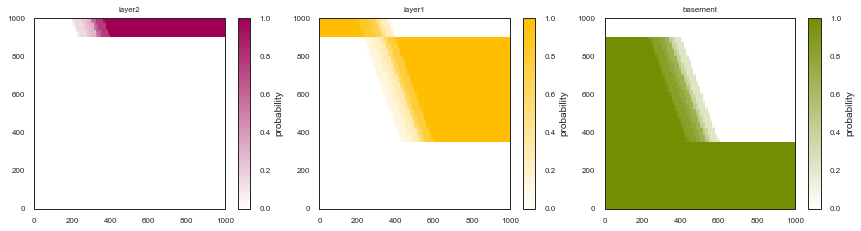

In [18]:
plot_probabilities(plot, prob_section, geo_model.grid.sections.resolution[0],
                  T=True, extent=[0,1000,0,1000])

2
(3, 10000)


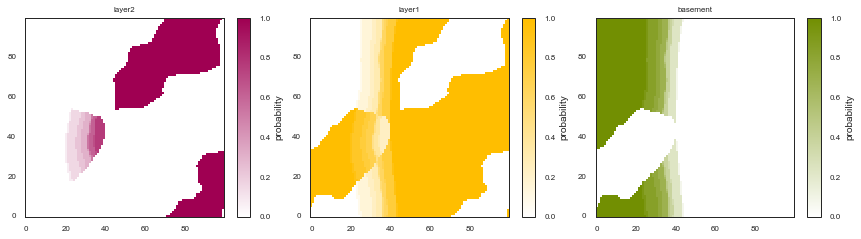

In [19]:
plot_probabilities(plot, prob_map, geo_model.grid.topography.resolution,
                  T=False)

### Entropy

In [20]:
from scipy.stats import entropy

In [21]:
ent_map = entropy(prob_map, base=2)
ent_sections = entropy(prob_section, base=2)
print(ent_sections.min(), ent_sections.max(), ent_map.min(), ent_map.max())

0.0 0.9957274520849256 0.0 0.9957274520849256


In [22]:
resolution=[80, 80]
restopo=[100, 100]

Text(0.5, 1.0, 'Map entropy')

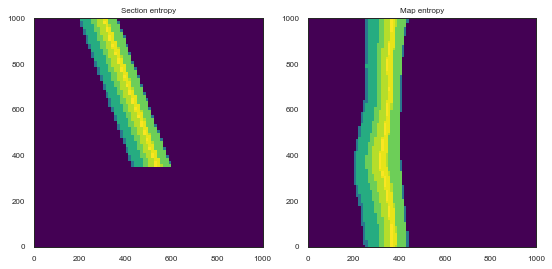

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,9))

vmin = 0
vmax = 1

section_ie1 = entropy(prob_section,base=2)[:80*80] # indexing in case there is more than one section
map_ie = entropy(prob_map,base=2)

extent=[0,1000,0,1000]
im = ax[0].imshow(section_ie1.reshape(resolution).T, origin='lower', cmap='viridis',extent=extent, vmin=vmin, vmax=vmax)
ax[0].set_title('Section entropy')
#add_colorbar(im, ax[0], label='cell entropy')
im = ax[1].imshow(map_ie.reshape(restopo), origin='lower', cmap='viridis',extent=extent, vmin=vmin, vmax=vmax)
ax[1].set_title('Map entropy')